# Introduction

Economic conditions can have a profound effect on individuals daily lives. A strong economy is often characterized by high employment rates, affordable living costs and high consumer spending. People spend more, businesses sell more as the environment is set for economic growth. Unfortunately, growth cannot continue forever, and these times of prosperity can be met with harsh downturns filled with uncertainty, lack of opportunity and instability. Extended periods of a weakening economy are known as recessions and although these periods may present difficulty in the lives of everyday individuals, having a better understanding of what these periods entail and recognizing the warning signs can help people be better prepared and move forward through these turbulent times.

This analysis will examine historical recession and economic indicator data pulled from the FRED website. We will identify what to expect from recessions along with trends and patterns between recessions and economic indicators that can give warning signs to a downturn in the economy. It is important to know that some of these trends using economic indicators have already been identified previously by other analyst so I am not pretending to have discovered them. However learning about past analysis has inspired me to to dive deeper into the relationships and explore new potential connections.

In [119]:
options(warn = -1)
options(repr.plot.width = 25, repr.plot.height = 9)

library(tidyverse)
library(ggplot2)
library(zoo) #yearmonth fxn
library(gridExtra)
library(glue)

In [120]:
myd = read_csv("/kaggle/input/us-economic-data/fredmeta.csv")
str(myd)

Rows: 924 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): date
dbl (8): recession, cpi, gdp, unemployment, m2, fed_funds, ten_two, residential

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


spc_tbl_ [924 × 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ date        : chr [1:924] "1/1/1947" "2/1/1947" "3/1/1947" "4/1/1947" ...
 $ recession   : num [1:924] 0 0 0 0 0 0 0 0 0 0 ...
 $ cpi         : num [1:924] 21.5 21.5 21.9 21.9 21.9 22 22.2 22.5 23 23 ...
 $ gdp         : num [1:924] 2183 NA NA 2177 NA ...
 $ unemployment: num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ m2          : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ fed_funds   : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ ten_two     : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ residential : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, "spec")=
  .. cols(
  ..   date = col_character(),
  ..   recession = col_double(),
  ..   cpi = col_double(),
  ..   gdp = col_double(),
  ..   unemployment = col_double(),
  ..   m2 = col_double(),
  ..   fed_funds = col_double(),
  ..   ten_two = col_double(),
  ..   residential = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [121]:
# rename columns
colnames(myd) = c("date","recession","cpi","gdp","unemployment","m2", "fedfunds","tentwo", "residential")

# convert to date format
myd$date = as.Date(myd$date, format = "%m/%d/%Y")
str(myd)

spc_tbl_ [924 × 9] (S3: spec_tbl_df/tbl_df/tbl/data.frame)
 $ date        : Date[1:924], format: "1947-01-01" "1947-02-01" ...
 $ recession   : num [1:924] 0 0 0 0 0 0 0 0 0 0 ...
 $ cpi         : num [1:924] 21.5 21.5 21.9 21.9 21.9 22 22.2 22.5 23 23 ...
 $ gdp         : num [1:924] 2183 NA NA 2177 NA ...
 $ unemployment: num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ m2          : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ fedfunds    : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ tentwo      : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 $ residential : num [1:924] NA NA NA NA NA NA NA NA NA NA ...
 - attr(*, "spec")=
  .. cols(
  ..   date = col_character(),
  ..   recession = col_double(),
  ..   cpi = col_double(),
  ..   gdp = col_double(),
  ..   unemployment = col_double(),
  ..   m2 = col_double(),
  ..   fed_funds = col_double(),
  ..   ten_two = col_double(),
  ..   residential = col_double()
  .. )
 - attr(*, "problems")=<externalptr> 


In [122]:
#check for null values
sum(is.na(myd))
colSums(is.na(myd))

[1] 1928

date    recession          cpi          gdp unemployment           m2 
           0            0            0          616           12          144 
    fedfunds       tentwo  residential 
          90          353          713

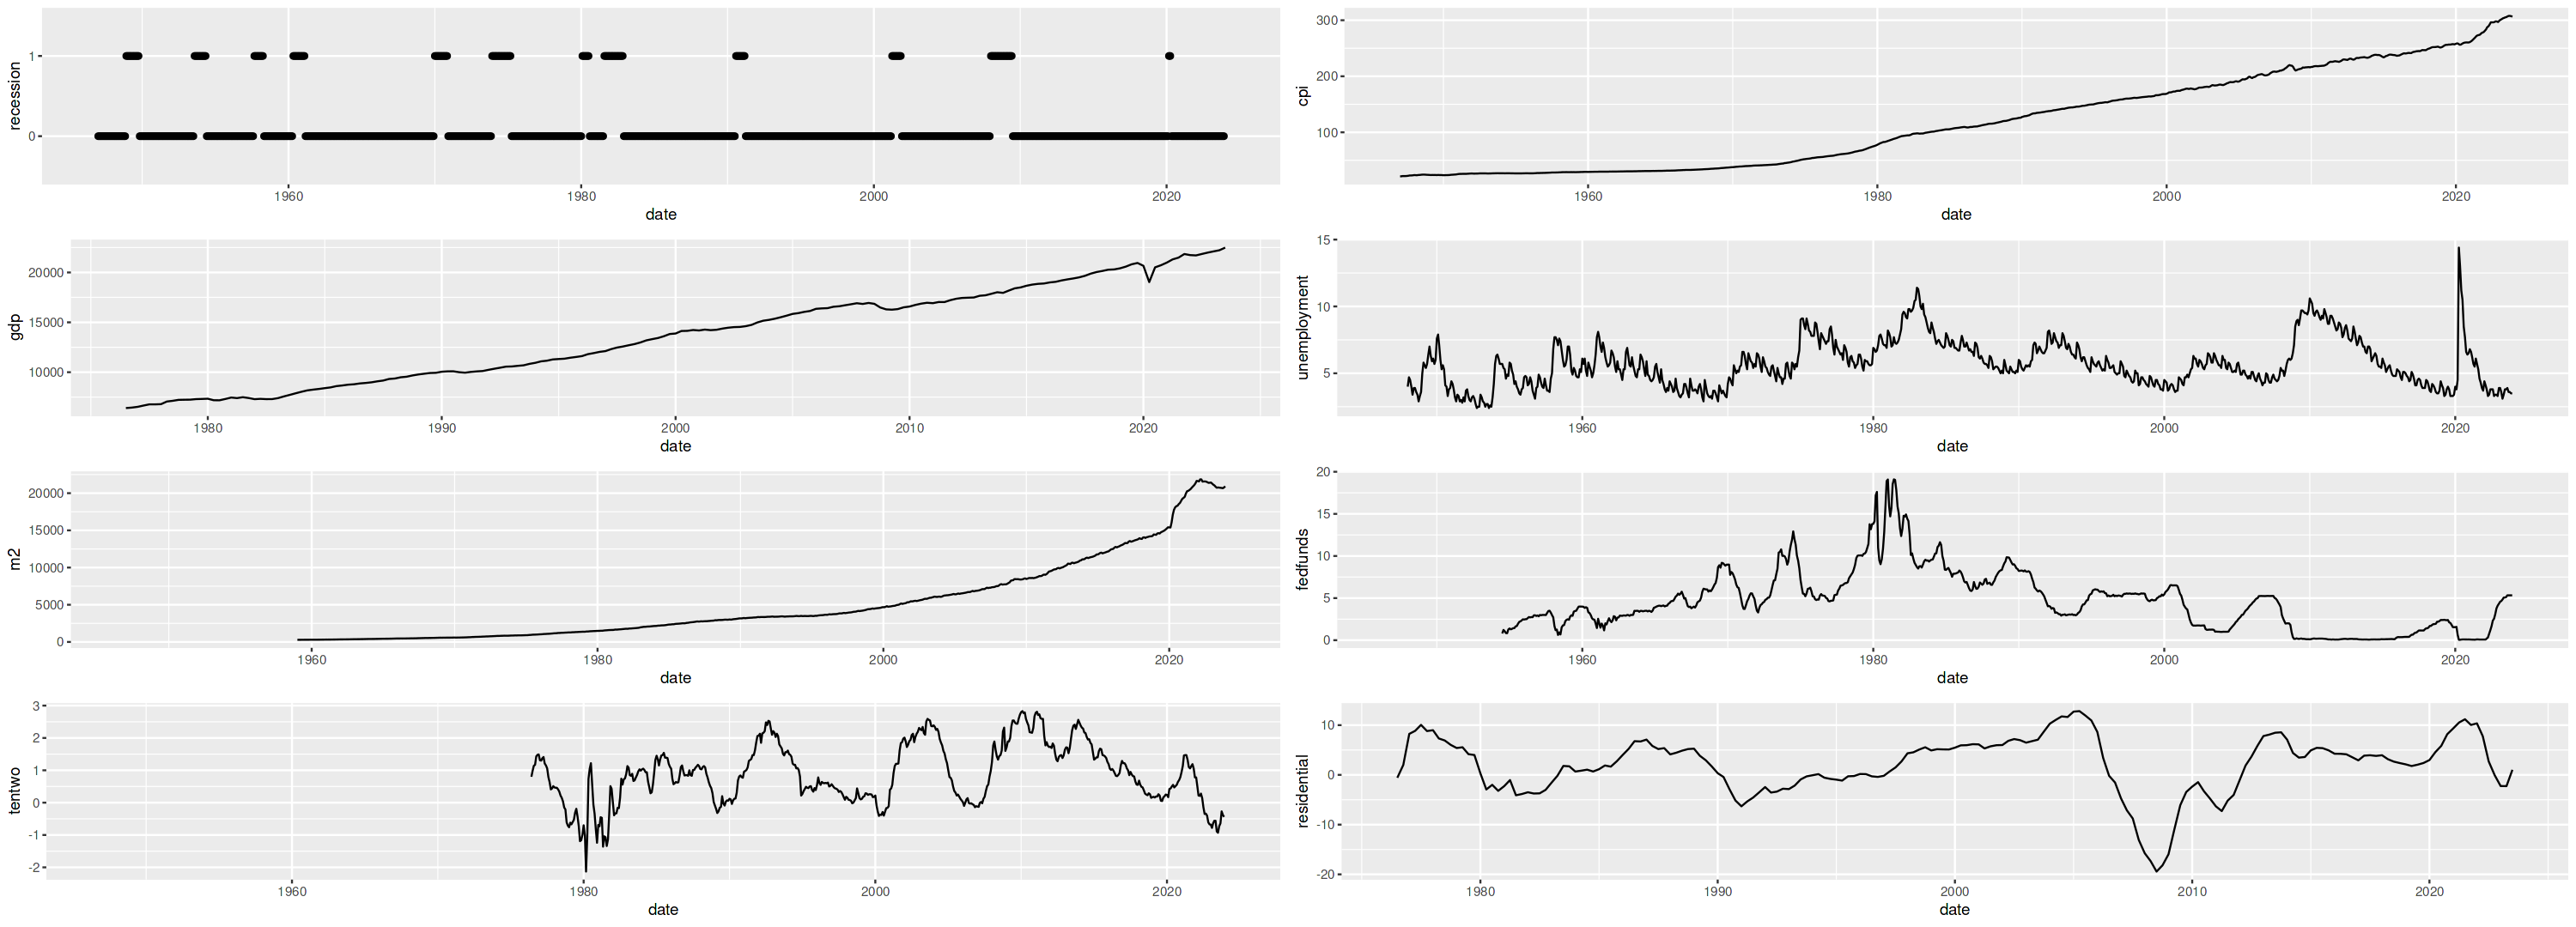

In [123]:
p1 = ggplot(myd, aes(x = date, y = as.factor(recession))) + geom_point() + labs(y = "recession")
p2 = ggplot(myd, aes(x = date, y = cpi)) + geom_line()
p3 = ggplot(na.omit(myd[!is.na(myd$gdp), ]), aes(x = date, y = gdp)) + geom_line()
p4 = ggplot(myd, aes(x = date, y = unemployment)) + geom_line()
p5 = ggplot(myd, aes(x = date, y = m2)) + geom_line()
p6 = ggplot(myd, aes(x = date, y = fedfunds)) + geom_line()
p7 = ggplot(myd, aes(x = date, y = tentwo)) + geom_line()
p8 = ggplot(na.omit(myd[!is.na(myd$residential), ]), aes(x = date, y = residential)) + geom_line()
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, ncol = 2)

# CPI, GDP, M2 mostly steady increase so likely useful to convert to pct change later on for analysis

# Recessions Overview

### Objectives
- Frequency of recessions
- Length of recessions and non-recessionary periods
- Disparities between inidividual recessions
- Explore notable trends from initial observations in more depth

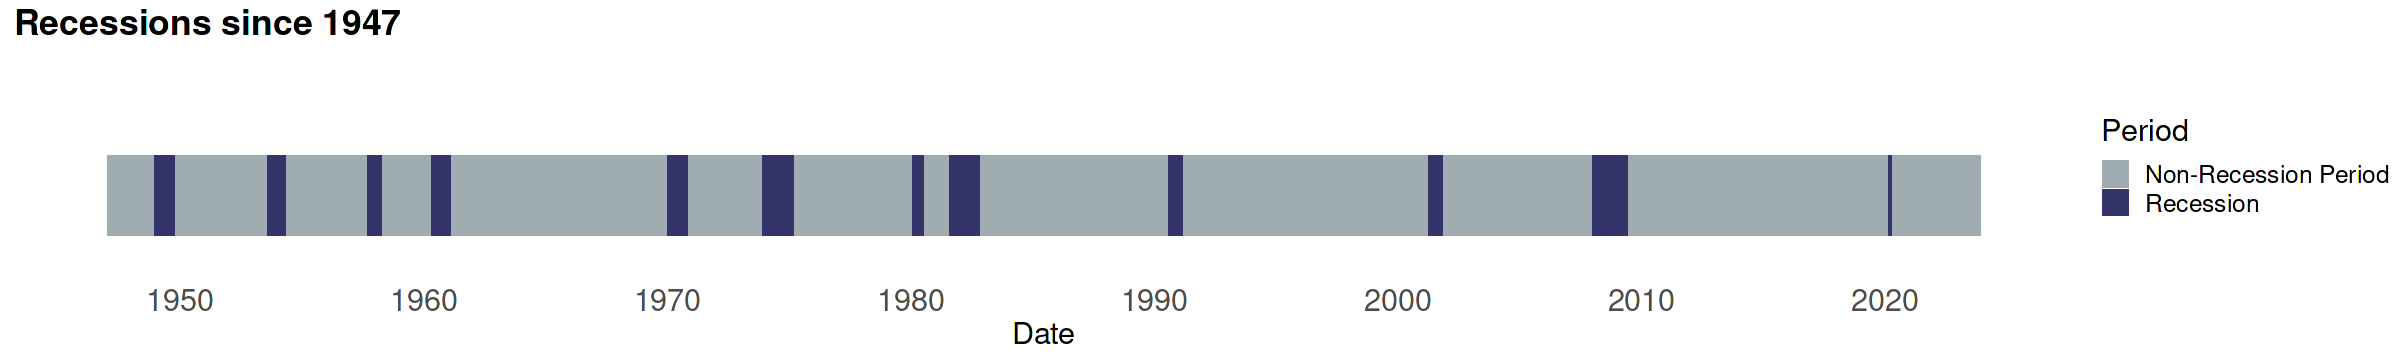

In [124]:
options(repr.plot.width = 20, repr.plot.height = 3)

# Recession Periods
# Tibble to identify individual recession periods and their lengths in months
recession_periods <- myd %>%
  mutate(recession_start = ifelse(lag(recession, default = first(recession)) == 0 & recession == 1, 1, 0),
         recession_end = ifelse(lead(recession, default = last(recession)) == 0 & recession == 1, 1, 0)) %>%
  filter(recession_start == 1 | recession_end == 1) %>%
  group_by(group = cumsum(recession_start)) %>%
  summarise(start_date = min(date), end_date = max(date),
            month_length = round((as.yearmon(end_date) - as.yearmon(start_date)) * 12) + 1) %>%
  ungroup() %>%
  select(-group)

# Non-Recessionary Periods
# Tibble to identify non-recessionary periods and their lengths in months
non_recession_periods <- recession_periods %>%
  mutate(next_recession_start = lead(start_date, order_by = start_date, default = last(start_date))) %>%
  filter(!is.na(next_recession_start)) %>%
  mutate(prev_recession_end = end_date) %>%
  mutate(months_to_next_recession = round((as.yearmon(next_recession_start) - as.yearmon(end_date)) * 12) + 1) %>%
  select(prev_recession_end, next_recession_start, months_to_next_recession)

# Create a sequence of breaks at the beginning of each decade
breaks <- seq(as.Date("1950-01-01"), as.Date("2020-01-01"), by = "10 years")

# Recession plot
p <- ggplot() +
  geom_rect(aes(xmin = min(myd$date), xmax = max(myd$date), ymin = 0.20, ymax = 0.55, fill = "Non-Recession Period"), 
            color = NA) +
  geom_rect(data = recession_periods, 
            aes(xmin = start_date, xmax = end_date, ymin = 0.20, ymax = 0.55, fill = "Recession"), 
            color = NA) +
  scale_fill_manual(name = "Period", values = c("Non-Recession Period" = "#9facb2", "Recession" = "#34346a")) +
  scale_x_date(breaks = breaks, date_labels = "%Y") +
  scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) +
  labs(title = "Recessions since 1947", x = "Date", y = "") +
  theme_minimal() +
  theme(text = element_text(size = 18),  
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        plot.title = element_text(size = 21, face = "bold"),
        panel.grid = element_blank(),
        axis.title.y = element_blank(),
        axis.text.x = element_text(size = 18),
        axis.title.x = element_text(size = 18))

# Print the plot
print(p)

# % time in recession
recession_pct <- round(sum(myd$recession == 1)/nrow(myd)*100, 2)

- Clearly much less time in recessions
- 12 recessions since 1947
- Around 13% of time in recession

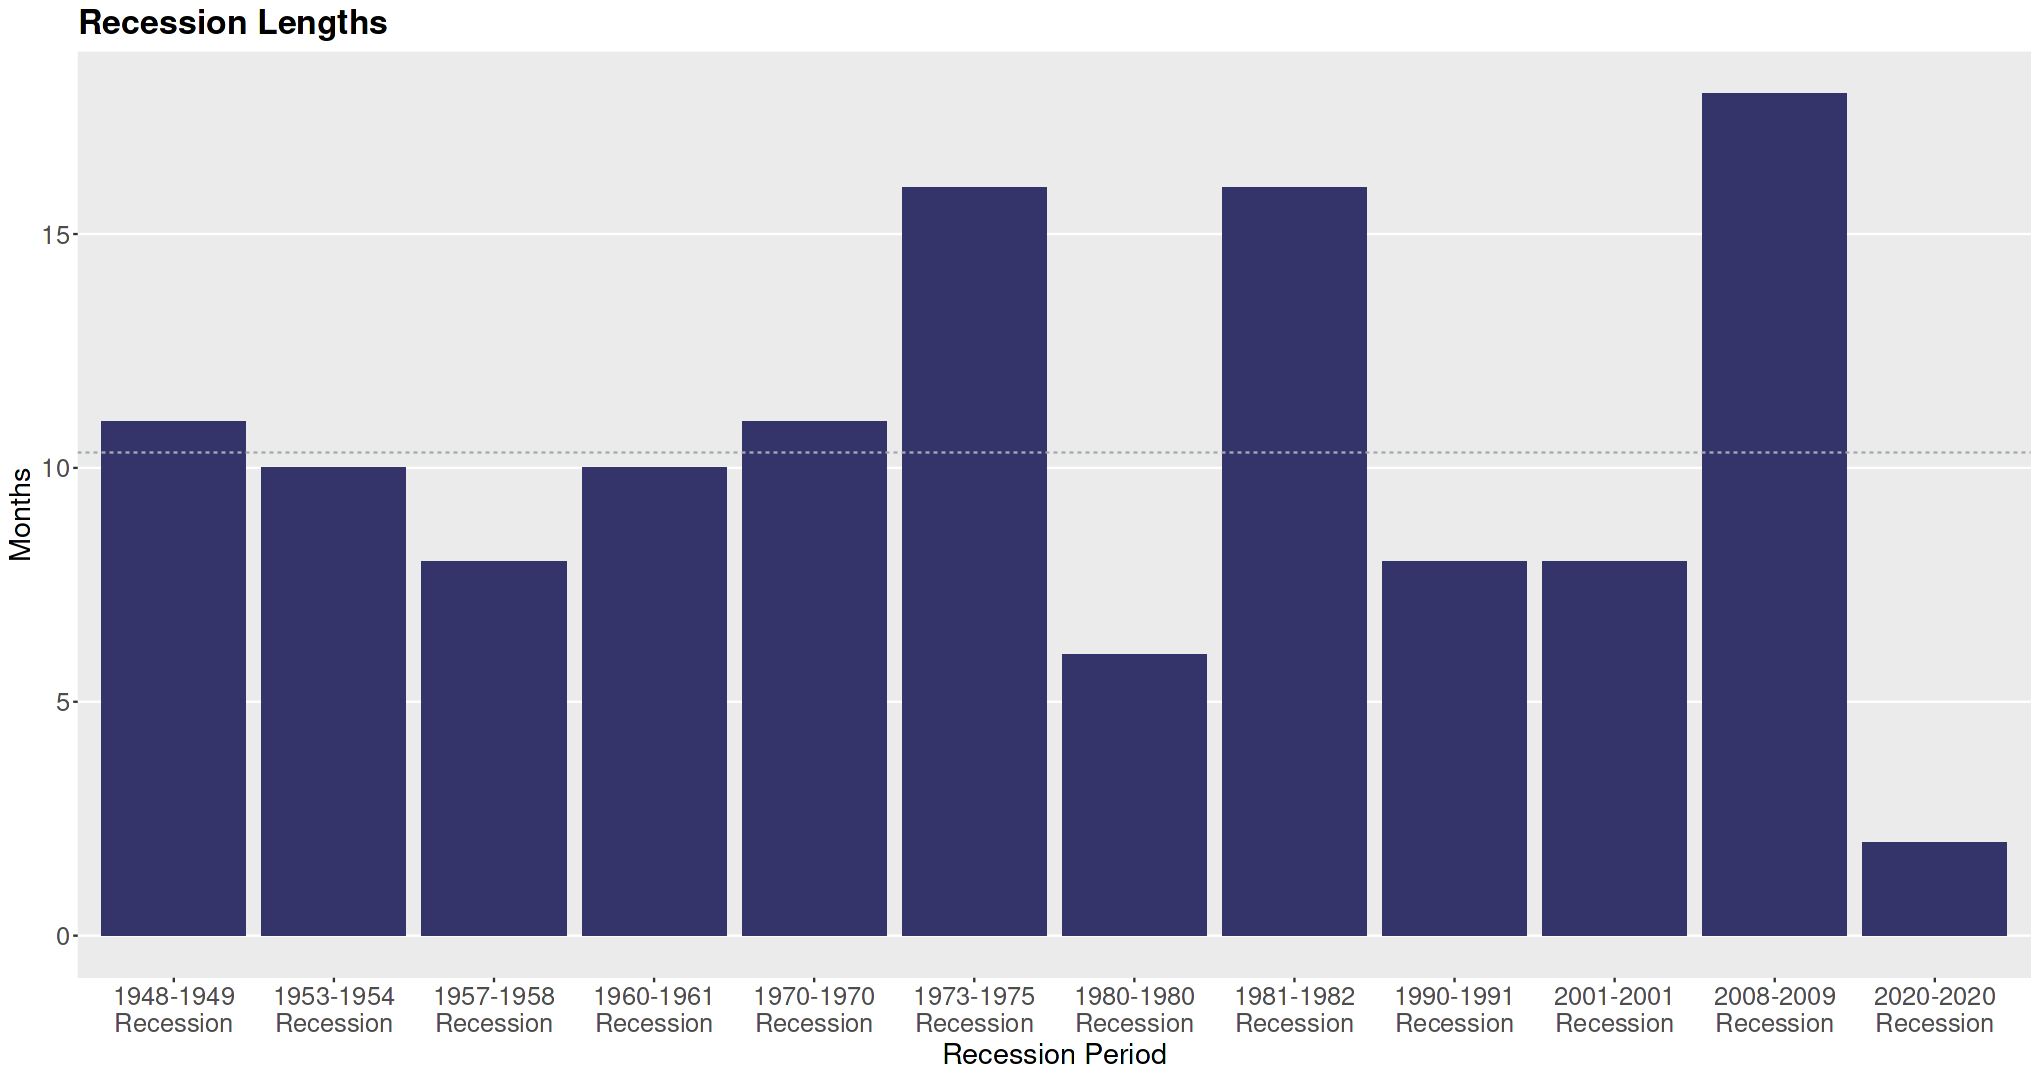

In [125]:
options(repr.plot.width = 17, repr.plot.height = 9)

# Recessions Plot
rp_year <- recession_periods %>%
  mutate(start_year = year(start_date),
         end_year = year(end_date),
         # Adding a line break before "Recession"
         period_label = paste(as.factor(start_year), as.factor(end_year), sep="-") %>%
                         paste0("\nRecession"))

ggplot(rp_year, aes(x = period_label, y = month_length)) +
  geom_bar(stat = "identity", fill = "#34346a") +
  geom_hline(yintercept = mean(rp_year$month_length), color = "#9facb2", linetype = "dashed") +
  #geom_text(aes(label = month_length), vjust = -0.5, size = 5) +
  labs(title = "Recession Lengths", x = "Recession Period", y = "Months") +
  theme(text = element_text(size = 17), 
        axis.text = element_text(size = 15),
        plot.title = element_text(size = 20, face = "bold"),
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())

# Average recession length for all periods
avg_length_all <- round(recession_periods %>%
  summarise(avg_recession_length = mean(month_length)) %>%
  pull(avg_recession_length), 2)

# Average recession length excluding 2020 recession
avg_length_excluding_2020 <- round(recession_periods %>%
  filter(end_date < "2020-01-01") %>%
  summarise(avg_recession_length = mean(month_length)) %>%
  pull(avg_recession_length), 2)

Now seperating and examining individual recessions 
Notice 2020 is by far the shortest and was caused by more of an external black swan event that typical economic cycle conditions so many may consider it an outlier. As such, some calculations throughout this report will be given including and excluding 2020.
- Average recession length is 10.33 or just under a year.
- Average excluding 2020 is 11.09.

- The two most recent recessions contained the longest and shortest recession.
- There seems to be greater variation in the length of recent recession compared to earlier recessions.

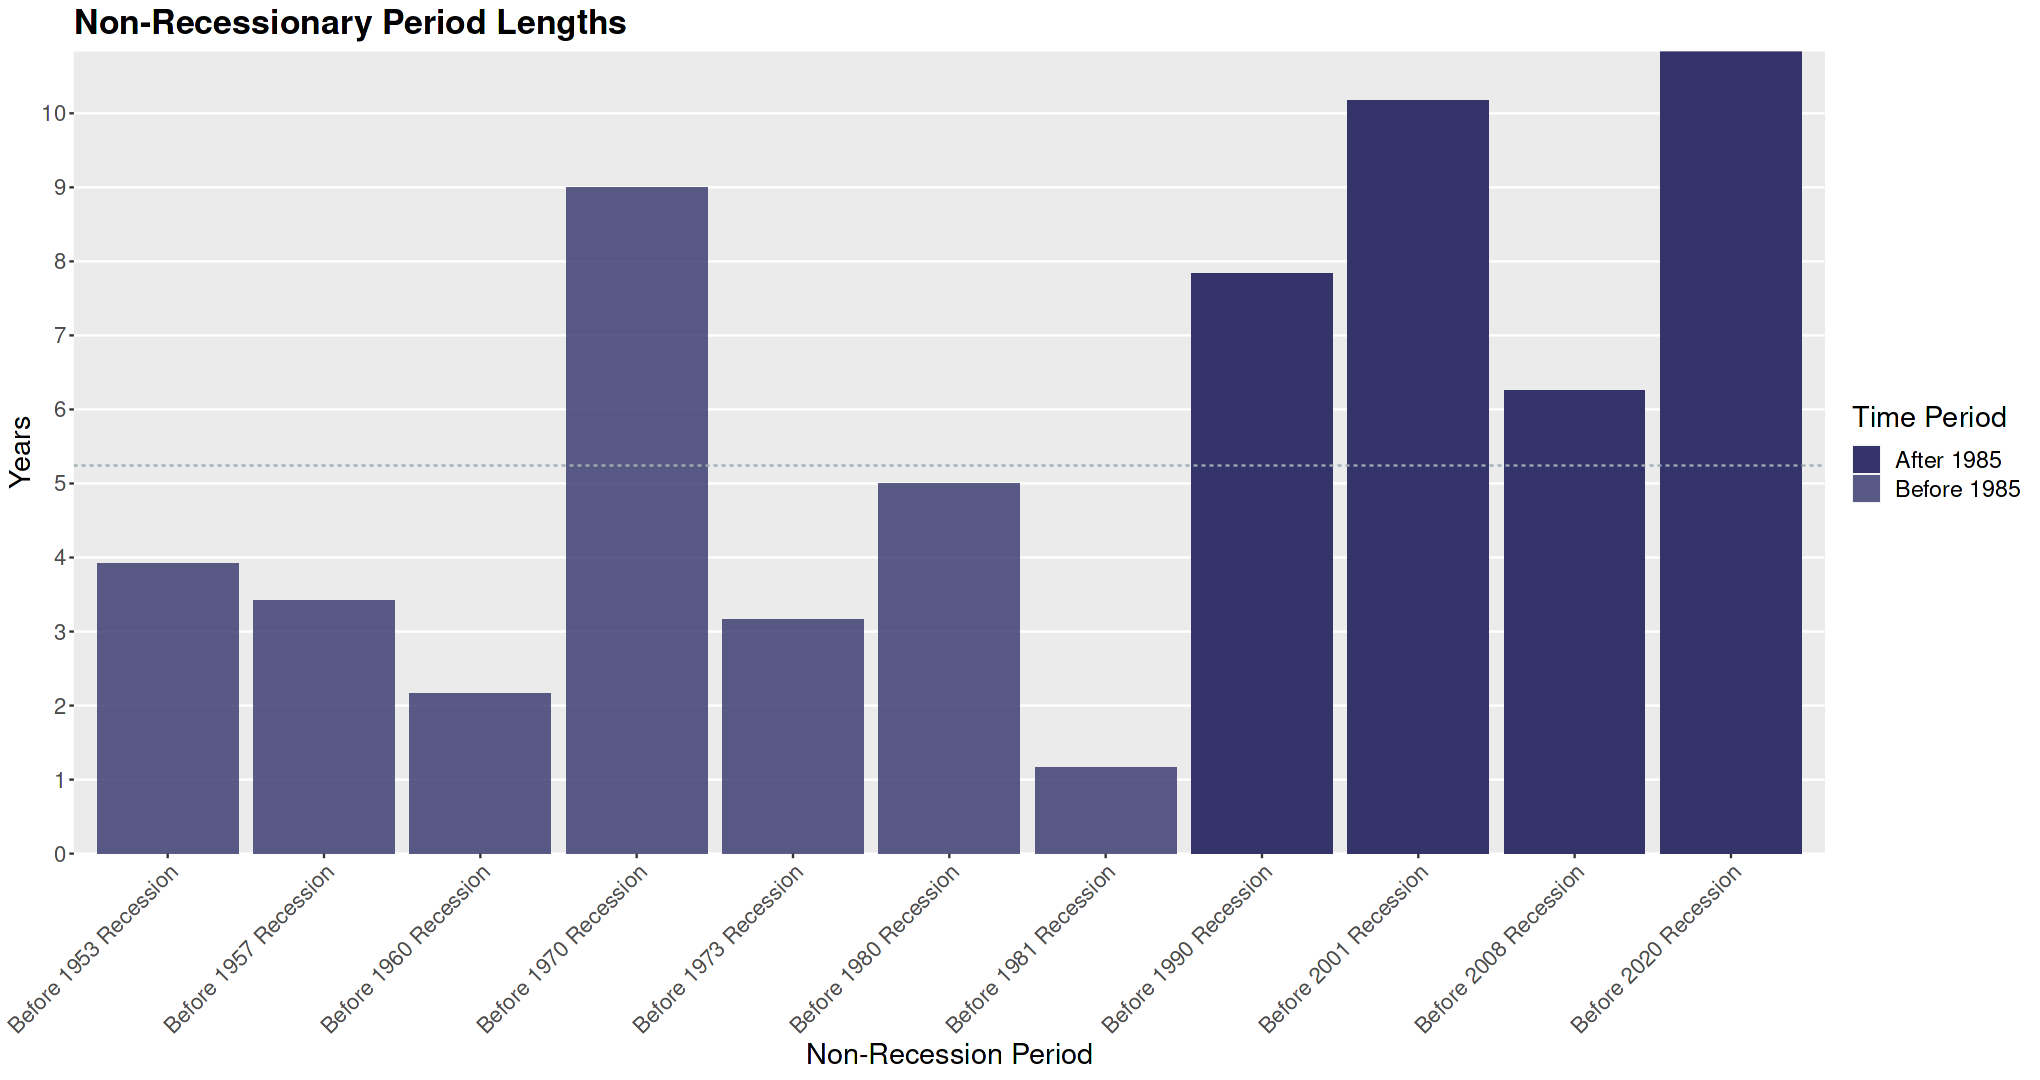

In [126]:
nrp_year = non_recession_periods %>%
  mutate(start_year = year(prev_recession_end),
         end_year = year(next_recession_start),
         period_label = paste("Before", as.factor(end_year), "Recession"),
         period_group = ifelse(end_year < 1985, "Before 1985", "After 1985"))

# Bar chart
ggplot(nrp_year, aes(x = period_label, y = months_to_next_recession / 12, fill = period_group)) +
  geom_bar(stat = "identity") +
  geom_hline(yintercept = mean(nrp_year$months_to_next_recession / 12), color = "#9facb2", linetype = "dashed") +
  scale_fill_manual(values = c("Before 1985" = "#34346acc", "After 1985" = "#34346a")) +
  scale_y_continuous(expand = c(0, 0), breaks = scales::pretty_breaks(n = 10)) +  # Add breaks argument
  labs(title = "Non-Recessionary Period Lengths", x = "Non-Recession Period", y = "Years", fill = "Time Period") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    text = element_text(size = 17), 
    axis.text = element_text(size = 13),
    plot.title = element_text(size = 20, face = "bold"),
    panel.grid.major.x = element_blank(), 
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank())

# Avg length of time from end date of one recession to start date of next date 
avg_length_to_next_recession <- round(non_recession_periods %>%
  summarise(avg_months_to_next_recession = mean(months_to_next_recession)) %>%
  pull(avg_months_to_next_recession), 2)

# not including 2020
avg_length_to_next_recession_2020 <- round(non_recession_periods %>%
  filter(prev_recession_end < "2020-01-01") %>%
  summarise(avg_months_to_next_recession = mean(months_to_next_recession)) %>%
  pull(avg_months_to_next_recession), 2)

- Average length of non-recessionary periods: 62 months (~5 years)
- Average length excluding 2020: 69 months (5.75 years)

- Recessions are sparsed out on average 5-6 years although definite variaiton with the shortest period being 14 months and the longest being 130 months or 10-11 years
- Pre 1985 vs Post 1985: Again there appears to be some diparity between earlier (before 1985) and recent recessions (after 1985). 7 of the 8 non-recessionary periods prior to 1990 have been shorter that the average while 4 of the 5 last non-recession periods since 1990 have been above the average. These diferences between time periods will be explored deeper later on in this analysis. First, now that we have values for the length of non-recessionary periods and their subsequent recession lengths, we will check if there is any correlation between the two.

### Is there any relationship between the length of non-recessionary period and the subsequent recession?

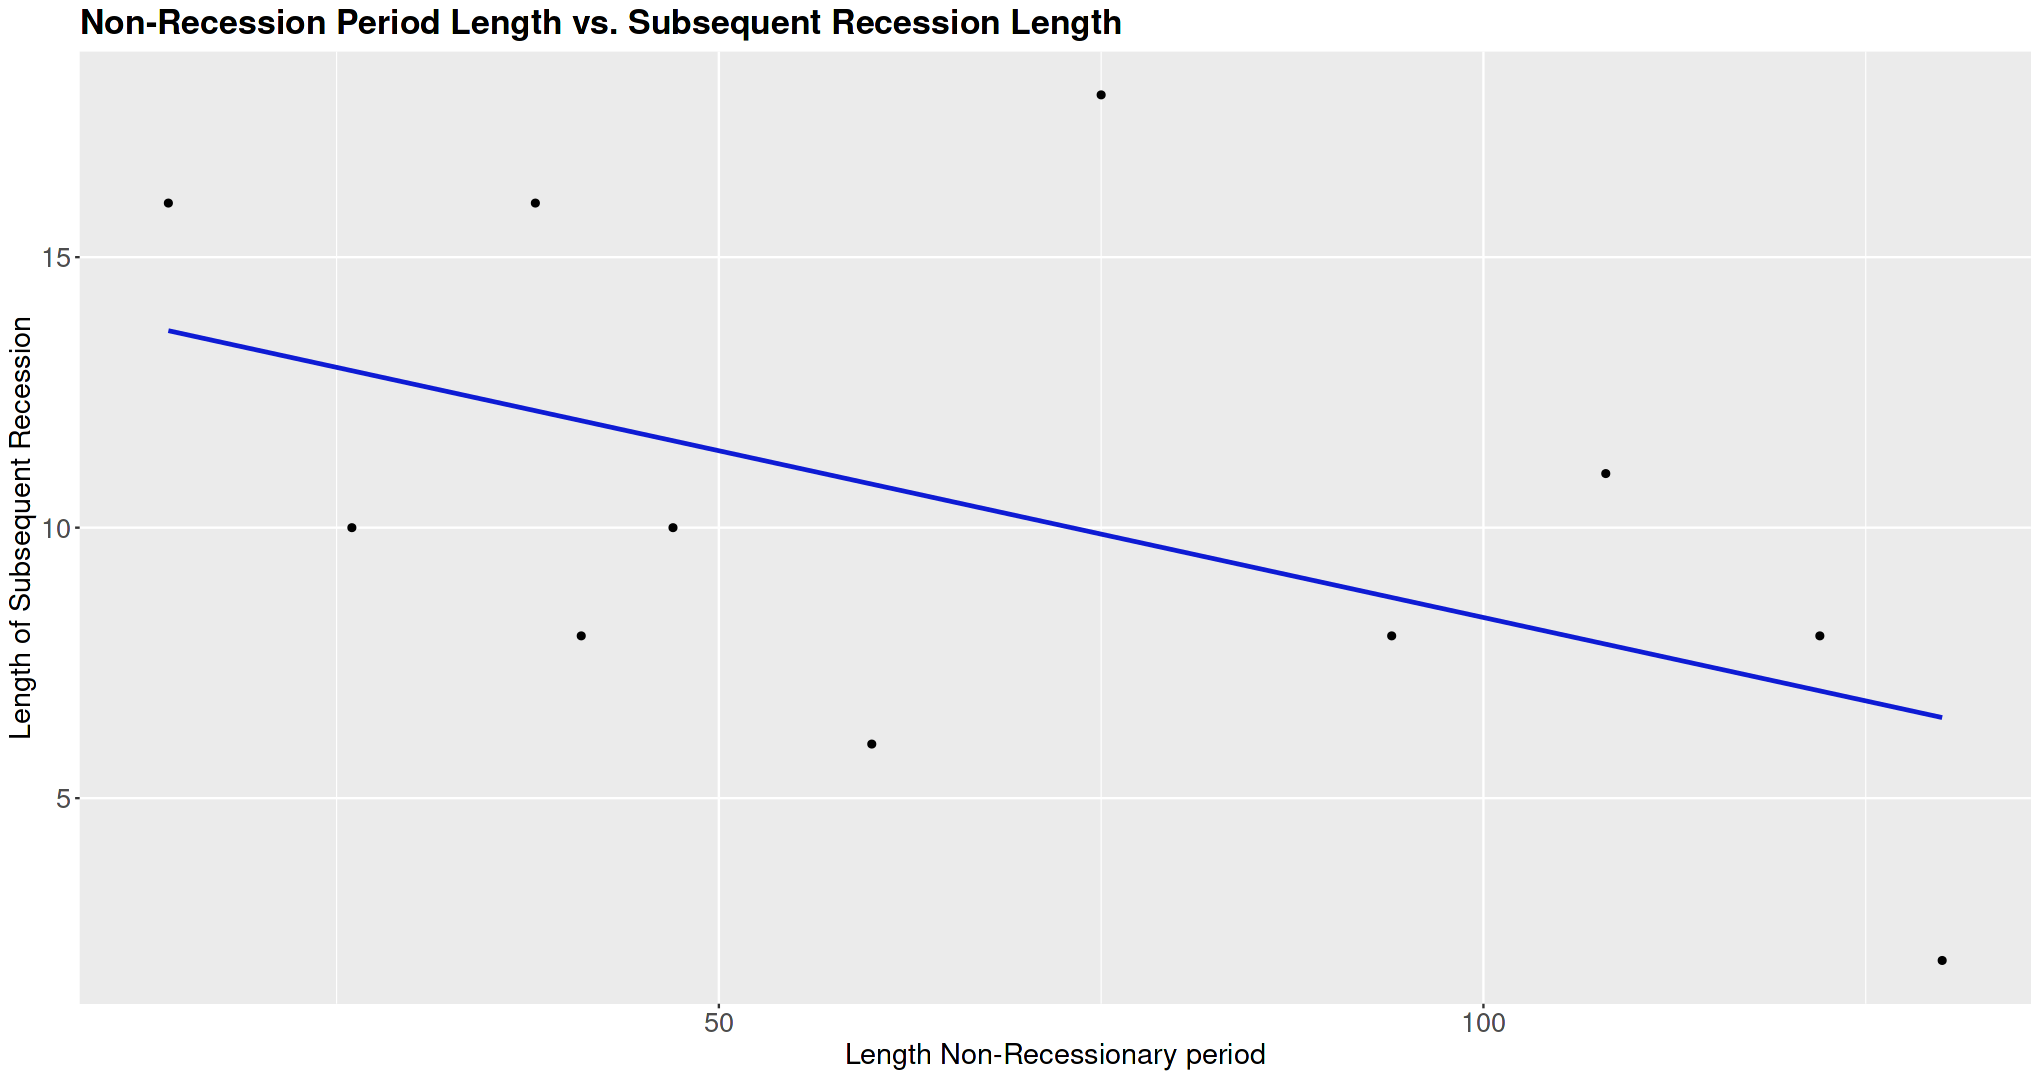

In [127]:
# Colum added for easier joining
recession_periods <- recession_periods %>%
  mutate(next_recession_start = lead(start_date))

# Join of non_recession_periods with recession_periods
analysis_df <- non_recession_periods %>%
  left_join(recession_periods, by = c("next_recession_start" = "start_date")) %>%
  select(recession_start = next_recession_start,
         prev_nonrecession_length = months_to_next_recession,
         recession_length = month_length) %>%
  slice(1:(n() -1))

# Correlation calculation
correlation_result <- cor(analysis_df$prev_nonrecession_length, analysis_df$recession_length, use = "complete.obs")

# Scatter Plot
ggplot(analysis_df, aes(x = prev_nonrecession_length, y = recession_length)) +
  geom_point() +
  labs(title = "Non-Recession Period Length vs. Subsequent Recession Length",
       x = "Length Non-Recessionary period",
       y = "Length of Subsequent Recession") +
  geom_smooth(formula = y ~ x, method = "lm", color = "#0e1bd4", se = FALSE) +
  theme(text = element_text(size = 17), 
        axis.text = element_text(size = 16),
        plot.title = element_text(size = 20, face = "bold"),
        panel.grid.minor.y = element_blank())

# Excluding 2020
# Filter out the row with recession_start equal to "2020-03-01"
analysis_filtered <- analysis_df %>%
  filter(recession_start != "2020-03-01")

# Calculate correlation
correlation_result_filtered <- cor(analysis_filtered$prev_nonrecession_length, analysis_filtered$recession_length, use = "complete.obs")

- Starting with 1953 recession since this dataset starts at 1947 and dont have suffient non-recessionary period length data for the 1948 recession
- Correlation
    - Including 2020 (-0.514) moderate negative
    - Excluding 2020 (-0.314) low negative correlation
- Using all the data appears to show a trend between the length of the non-recessionary period and the subsequent recession length, specifially that longer non-recessioanry periods may lead to shorter recession lengths and vice-versa. It is important to note that it is only a moderate correlation of -0.5 and excluding the 2020 recession cuts this correlation result down to -0.314.

# Early vs Recent Recessions (*Before and After 1985*)

As stated previously, there appears to be notable differences between recessions in in the first and second half of the data. There may be insight to be gained not only comparing the two groups, but also in analyzing more recent recessions specifically as it may provide better insight in to what we can expect in our next economic downturn. The data will be split just around half using 1985 as the cut-off point.

"Early" period: 1947-1985

"Recent" period: 1985-2023

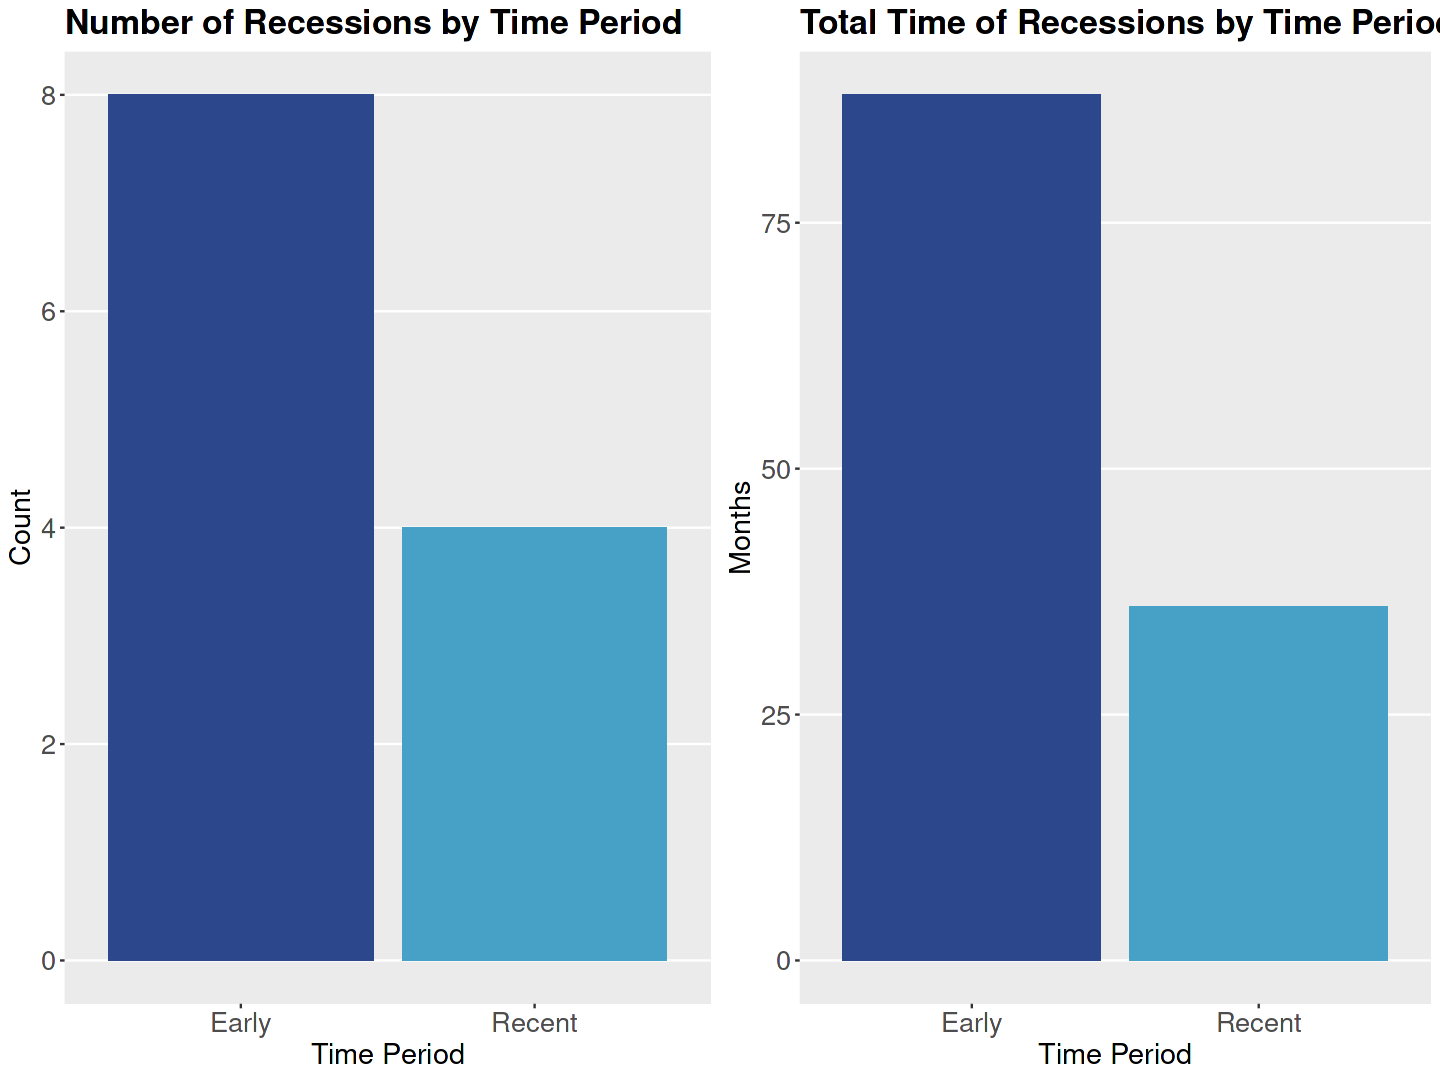

In [134]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Grouping recession periods into two groups, before 1985 and after 1985
# Have to make groups factors to control order of bars in bar chart
recession_periods <- recession_periods %>%
  mutate(group = factor(ifelse(start_date < "1985-01-01", "Early", "Recent"),
                        levels = c("Early", "Recent")))

# Bar chart of recession lengths and number of recessions by group

# Number of Recessions by Group
plot1 <- ggplot(recession_periods, aes(x = group, fill = group)) +
  geom_bar() +
  labs(title = "Number of Recessions by Time Period", x = "Time Period", y = "Count", fill = "Time Period") +
  scale_fill_manual(values = c("Early" = "#2d478d", "Recent" = "#47a0c6"),
                    labels = c("Early" = "Before 1985", "Recent" = "After 1985")) +
  theme(text = element_text(size = 17), 
        axis.text = element_text(size = 16),
        plot.title = element_text(size = 20, face = "bold"),
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.y = element_blank(),
        legend.position = "none")

# Recession Lengths by Group
plot2 <- ggplot(recession_periods, aes(x = group, y = month_length, fill = group)) +
  geom_bar(stat = "identity") +
  labs(title = "Total Time of Recessions by Time Period", x = "Time Period", y = "Months", fill = "Time Period") +
  scale_fill_manual(values = c("Early" = "#2d478d", "Recent" = "#47a0c6"),
                    labels = c("Early" = "Before 1985", "Recent" = "After 1985")) +
  theme(text = element_text(size = 17), 
        axis.text = element_text(size = 16),
        plot.title = element_text(size = 18, face = "bold"),
        panel.grid.major.x = element_blank(), 
        panel.grid.minor.y = element_blank(),
        legend.position = "none")

grid.arrange(plot1, plot2, ncol = 2)

Number of Recessions
- Early Period: 8
- Recent Period: 4

Total Months in Recession
- Early period: 88
- Recent Period: 36

Clear disparity between the two as recent times have had half as much instances of recession along with a shorter total duration. The shorter total time may be expected considering the less frequent instances of recession so next we will look at the ranges and averages for recessions in each period.

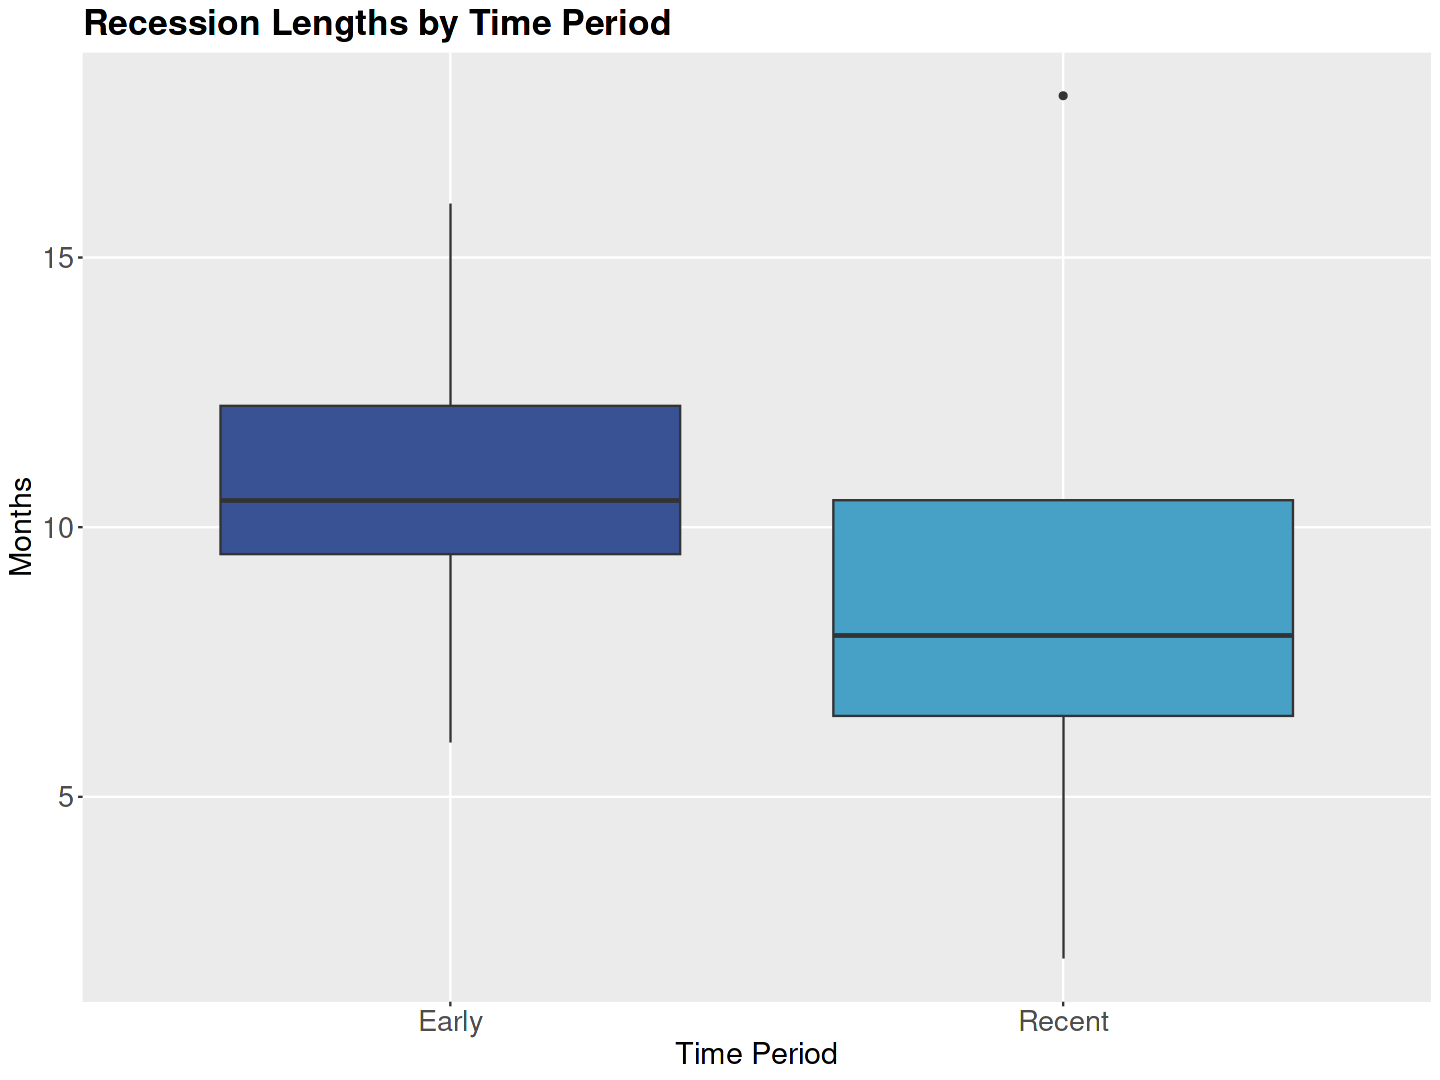

In [135]:
ggplot(recession_periods, aes(x = group, y = month_length, fill = group)) +
  geom_boxplot() +
  labs(title = "Recession Lengths by Time Period", x = "Time Period", y = "Months", fill = "Time Period") +
  scale_fill_manual(values = c("Early" = "#395294", "Recent" = "#47a0c6"),
                    labels = c("Early" = "Before 1985", "Recent" = "After 1985")) + 
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 17),
        plot.title = element_text(size = 21, face = "bold"), 
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        legend.position = "none")

# Avg length older vs recent
avg_length_by_group <- round(recession_periods %>%
  group_by(group) %>%
  summarise(avg_recession_length = mean(month_length)) %>%
  pull(avg_recession_length), 2)

- Median recession length early period: 11 months
- median recession length recent period: 6 months
- Average recession length early period: 11 months
- Average recession length recent period: 9 months

So recessions in more recent times are are both shorter and less frequent.

However, recent recessions are not as consistent in length and have a much wider range, containg both the longest and shortest instances so there may be more unpredicatbility with the severity of each recession.

# Economic Indicators 
Now we will look at some economic indicators often linked with recessions and visualize the historical data alongside recession data to look for any trends. Calcualtions will also be performed to find specific quantitative values for those trends. I will be focusing on the three indicators that I found the most useful although the dataset contains other indictors that can furthur be explored.
The following visualizations include grey shaded regions over the plots to indicate recessionary periods. Not all of the indicators presented had data accessible since 1947 so I used data as far back as I could find and beleive it can still provide useful insights.

## 10 vs 2 Year Treasury Yield

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 9)

myd_tentwo = myd %>% filter(!is.na(tentwo))

# 10 vs 2 year plot
ggplot(myd_tentwo, aes(x = date, y = tentwo)) +
  labs(title = "10 vs 2 Year Treasury Yield and Recessions (1976-2023)", x = "Time", y = "Percent") +
  geom_line() +
  geom_hline(yintercept = 0) +
  geom_rect(data = recession_periods %>% 
            filter(start_date >= min(myd_tentwo$date)), inherit.aes = FALSE,
            aes(xmin = start_date, xmax = end_date, ymin = -Inf, ymax = Inf),
            fill = "#adbbbd", alpha = 0.5) +
  geom_ribbon(aes(ymin = pmin(tentwo, 0), ymax = 0), fill = "#0e1bd4", alpha = 0.5) +
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 17),
        plot.title = element_text(size = 21, face = "bold"),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())

The above visualization shows the two year vs ten year treasury yield since 1976 as that is the earliest data I could find. The dark grey shaded areas represent recession periods and the purple shaded areas highlight the inversion periods of the ten minus two year yield which are commonly associated with recessions.

- Main observation is that an inversion of the yield curve closely precedeing every recession other than the 2020 recession, alhtough even then, the yield curve was very close to inverting and reached a level as small as 0.05%.

- Again there were some differences between periods before and after 1985
    - Avg time is 378 days (just over a year) from end of the first inversion period >1 to start of subsequent recession since 1985
    - Earlier recessions occured while yield curve was still inverted while in recent times, the yield curve reverted back prior to recession
    - Earlier periods had steeper inversion periods.
    - Recent periods have multiple inversion and reversions in between recessionary periods
        - although always occured within under 2 years of first inversion regardless
    
- Yield curve usually reaches a max between 2-3% before begins declining

Inversion Period Lengths

In [ ]:
# Tibble for each inversion period and their length in months
inversion_periods <- myd %>%
  mutate(inversion_start = ifelse(lag(tentwo, default = first(tentwo)) >= 0 & tentwo < 0, 1, 0),
         inversion_end = ifelse(lead(tentwo, default = last(tentwo)) >= 0 & tentwo < 0, 1, 0)) %>%
  filter(inversion_start == 1 | inversion_end == 1) %>%
  group_by(group = cumsum(inversion_start)) %>%
  summarise(start_date = min(date), end_date = max(date), 
            month_length = round((as.yearmon(end_date) - as.yearmon(start_date)) * 12) + 1) %>%
  ungroup() %>%
  mutate(end_date = if_else(row_number() == n(), NA_Date_, end_date),
         month_length = if_else(row_number() == n(), NA_integer_, month_length)) %>%
  select(-group)

inversion_periods

# Average length of inversion period
avg_length_inversion <- round(mean(inversion_periods$month_length[!is.na(inversion_periods$month_length)]), 2)

# Averag length of of inversion excluding those lasting only a month
avg_length_inversion_excluding_short <- round(mean(inversion_periods$month_length[!is.na(inversion_periods$month_length) & inversion_periods$month_length > 1]), 2)

- Avergae length of inverson period is 6.64 months
- Average length excluding the inversions that lasted only a month: 8.75 months.
    - All of the inversion that only lasted a month were accompanied by other inversions within that same non-recessionary-period


- NOTE: 2022 inversion period still ongoing. As of December 2023 that inversion has lasted 17 months.
- Have to go back to early 80s to see yield curve inverted for this long

### Is there a relationship between the length of the inversion period and the legnth of the subsequent recession length?

In [ ]:
# Grouping the multiple inversion periods that occur within same nonrecessionary period
inversion_periods_grouped = inversion_periods %>%
    mutate(group = factor(case_when(
        start_date >= "1985-01-01" & end_date <= "1992-01-01" ~ "1990-08-01",
        start_date >= "1995-01-01" & end_date <= "2002-01-01" ~ "2001-04-01",
        start_date >= "2005-01-01" & end_date <= "2010-01-01" ~ "2008-01-01",
        TRUE ~ NA
    ), levels = c("1990-08-01", "2001-04-01", "2008-01-01")))

inversion_periods_grouped = inversion_periods_grouped %>%
    filter(!is.na(group)) %>%
    group_by(group) %>%
    summarise(total_inversion_length = sum(month_length))

# Convert group column to date format
inversion_periods_grouped$group <- as.Date(inversion_periods_grouped$group)


# Combine with recession periods 
inversion_periods_grouped = inversion_periods_grouped %>%
    left_join(recession_periods, by = c("group" = "start_date")) %>%
    select(group, total_inversion_length, month_length)
inversion_periods_grouped

# Correlation calcualtion
correlation_result = round(cor(inversion_periods_grouped$total_inversion_length, inversion_periods_grouped$month_length, use = "complete.obs"), 2)


output <- glue("Correlation result: {correlation_result}")
cat(output)

Grouped multiple inversions belonging to the same non-recessionary period. Only had three cases but still interested in seeing result. Only used recessions after 1985 because as mentioned before, that is when recession began occuring after the reversion.

## Unemployment Rate

In [ ]:
# Unemployment Rate plot
ggplot(myd, aes(x = date, y = unemployment)) +
  labs(title = "Unemployment Rate and Recessions (1947-2023)", x = "Time", y = "Percent") + 
  geom_line() +
  geom_rect(data = recession_periods, inherit.aes = FALSE,
            aes(xmin = start_date, xmax = end_date, ymin = -Inf, ymax = Inf),
            fill = "#9facb2", alpha = 0.5) +
  geom_ribbon(aes(ymin = pmin(unemployment, 5), ymax = 5), fill = "#0011ff", alpha = 0.5) +
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 17),
        plot.title = element_text(size = 21, face = "bold"),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())

Above is the unemployment rate with recession shading since 1947. Keep in mind, the increase in unemployment rate is often used as the definition of a recession so you will clearly see the unemployment rate ticking up in the grey shaded areas and the maximum unemployment being reaced is very close to the ends of recessions and it continously ticking downwards thereafter. This is nothing new so we will instead look into what precedes this rise in unemployment rate and see if there are any thresholds and trends observed before the recession starts.

The purple shaded areas shade the threshold in which recessions appear to occur which is in under 5%  unemployment environemnts. Once beow this threshold is reached and the unemployment rate beigns ticking up again consecutive quarters, it may indicate a looming recession.

### What is the threshold for total drop in unemployment preceding recessions?

In [ ]:
# Calcualting unemployment rate change prior to each recession
unemployment_change <- recession_periods %>%
  # Create column for the next recession's start date
  mutate(next_recession_start = lead(start_date, default = last(start_date))) %>%
  rowwise() %>%
  mutate(
    unemployment_end = myd$unemployment[which(myd$date == end_date)],
    unemployment_start_next = myd$unemployment[which(myd$date == next_recession_start)],
    unemployment_diff = unemployment_start_next - unemployment_end
  ) %>%
  select(start_date, end_date, unemployment_diff, next_recession_start)

unemployment_change

Here I calcualted the drop in unemployment from the end the recession to the start of the next.

- 75% of recesssions occured post >2% drop in unemployment
- 75% of recessions post 1985 had >3% drop in unemploymnt 

I will now see if there is anything of note using the maximum an minimum range during the nonrecessionary period instead of using the difference from the ends and starts of recessions.

### What about patterns in the drop of unemployment from the  maximum to the minimum?

In [ ]:
recession_unemployment <- recession_periods %>%
  mutate(
    next_recession_start = lead(start_date, order_by = start_date, default = last(start_date))
  ) %>%
  filter(!is.na(next_recession_start)) %>%
  rowwise() %>%
  mutate(
    # Period between the end of this recession and the start of the next
    period_end = end_date,
    period_start_next = next_recession_start,
    # Max unemployment rate after the end of this recession and before the next
    max_unempl = max(myd$unemployment[myd$date > period_end & myd$date < period_start_next], na.rm = TRUE),
    # Min unemployment rate in the same period
    min_unempl = min(myd$unemployment[myd$date > period_end & myd$date < period_start_next], na.rm = TRUE),
    # Difference between max and min unemployment rates in the period
    unempl_diff = max_unempl - min_unempl
  ) %>%
  # Ungroup to avoid rowwise operations moving forward
  ungroup() %>%
  # Select relevant columns
  select(end_date, next_recession_start, max_unempl, min_unempl, unempl_diff)

recession_unemployment

Here I calculated the maximum drop from the peak unemlployment rate preceding each recession. There was nothing that really stood out using this difference method compared to the previous.

## Real Residential Property Prices

In [ ]:
myd_residential = na.omit(myd[!is.na(myd$residential), ])

ggplot(myd_residential, aes(x = date, y = residential)) +
  labs(title = "Real Residential Price Growth and Recessions (1971-2023)", x = "Time", y = "Percent") + 
  geom_line() +
  geom_rect(data = recession_periods %>% 
              filter(start_date >= min(myd_residential$date)), inherit.aes = FALSE,
            aes(xmin = start_date, xmax = end_date, ymin = -Inf, ymax = Inf),
            fill = "#adbbbd", alpha = 0.5) +
  geom_ribbon(aes(ymin = pmin(residential, 0), ymax = 0), fill = "#0e1bd4", alpha = 0.5) +
  theme(text = element_text(size = 18), 
        axis.text = element_text(size = 17),
        plot.title = element_text(size = 21, face = "bold"),
        panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank())

- Negative rate often suitable environemnt for recession (similar to Ten vs Two yield curve)
- Continous decline in general precede recessions
    - Did not occur in 2000 however

### How large is the drop in the real residential price rate?

In [ ]:
residential_diff <- recession_periods %>%
  mutate(next_recession_start = lead(start_date, default = last(start_date))) %>%
  filter(!is.na(next_recession_start)) %>%
  rowwise() %>%
  mutate(
    period_end = end_date,
    period_start_next = next_recession_start,
    max_residential = max(myd_residential$residential[myd_residential$date > period_end & myd_residential$date < period_start_next], na.rm = TRUE),
    min_residential = min(myd_residential$residential[myd_residential$date > period_end & myd_residential$date < period_start_next], na.rm = TRUE),
    residential_diff = max_residential - min_residential
  ) %>%
  ungroup() %>%
  select(end_date, next_recession_start, max_residential, min_residential, residential_diff)

residential_diff

# Conclusion
Recent times appear to show more favorable economic cycle conditions as we have had a notable drop in the frequency of recessions while maintaing a length slightly lower than average. The disparity in lengths however is much more variable post 1985 which may mitigate some those benefits.

Among economic indicators, the 10-year minus 2-year Treasury yield spread and the unemployment rate have demonstrated the most consistent trends preceding recessions. Typically, the inversion of the yield curve tends to precede economic downturns, a pattern observed since 1985. Meanwhile, fluctuations in the unemployment rate and residential market also offer insights, particularly when unemployment rate is below 5 percent and house prices show steep declines.

Currently, both the 10-year minus 2-year yield spread and the unemployment rate have reached thresholds identified in this notebook as signaling a recession. While the yield curve has yet to revert, it is on the brink of doing so, with the potential to become the longest inversion in history if it persists for another two months. Additionally, the current drop in the unemployment rate is the steepest observed before a recession, underscoring the severity of the economic shift. It will be interesting to see what this next economic dowturn entails but as for now I hope this analysis provided a clearer picture of what to expect from recessions and some useful predictors to look out for.